In [139]:
#import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller

from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_squared_error
from math import sqrt

import plotly.express as px 
from sklearn import metrics 
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
import tensorflow as tf 

import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)



In [120]:
df = pd.read_csv('job_geog_data.csv')
df.head()

colorado_df = df[df["state"] == 'CO']
colorado_df.head(100)

,post_date,state,industry,count_id_indexed
96,2020-03-01,CO,NaN,1.0000
97,2020-03-01,CO,Communication,1.0000
98,2020-03-01,CO,Construction,1.0000
99,2020-03-01,CO,Energy,1.0000
100,2020-03-01,CO,Entertainment,1.0000
...,...,...,...,...
5055,2020-03-06,CO,Wholesale,1.2503
6032,2020-03-07,CO,NaN,1.0681
6033,2020-03-07,CO,Communication,1.1555
6034,2020-03-07,CO,Construction,1.1143


Text(0, 0.5, 'Labor Index')

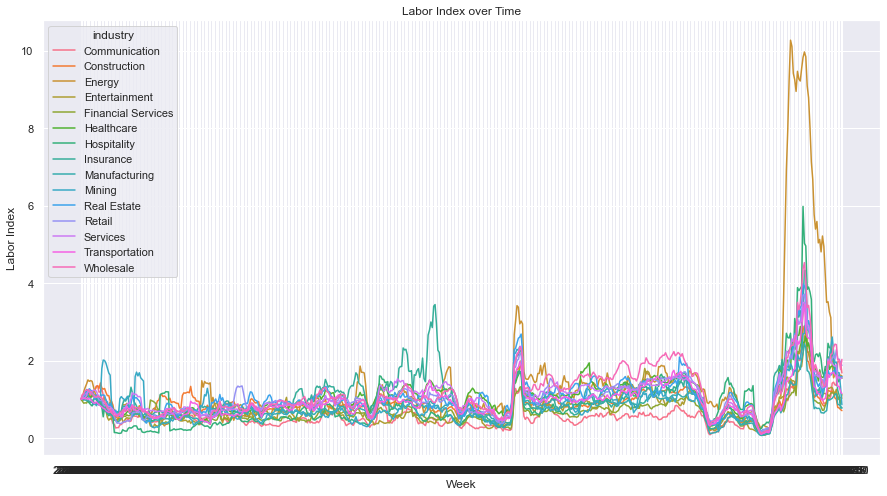

In [412]:
colorado_df["industry"].unique()

co_wide = colorado_df.pivot("post_date", "industry", "count_id_indexed")
co_wide.head()

sns.set(rc = {'figure.figsize':(15,8)})
p = sns.lineplot(data=colorado_df, x="post_date", y="count_id_indexed", hue="industry");
p.set(title="Labor Index over Time")
p.set_xlabel('Week')
p.set_ylabel('Labor Index');


In [122]:
colorado_df["post_date"].max()

'2021-08-31'

In [123]:
colorado_df['Weeks'] = colorado_df['post_date'].astype('datetime64[ns]')
updated = colorado_df.drop(columns=['post_date','state'])
updated.head()
colorado_jobs = updated.groupby('industry').resample('W-Sun', on='Weeks').mean()
colorado_jobs.reset_index(inplace=True)
display(colorado_jobs.head())

,industry,Weeks,count_id_indexed
0,Communication,2020-03-01,1.000000
1,Communication,2020-03-08,1.115743
2,Communication,2020-03-15,1.222900
3,Communication,2020-03-22,0.894771
4,Communication,2020-03-29,0.336886


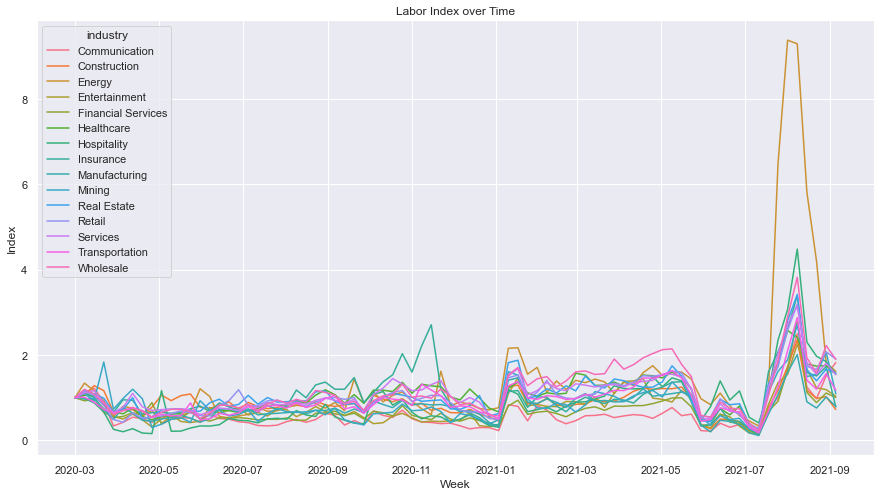

In [415]:
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.lineplot(data=colorado_jobs, x="Weeks", y="count_id_indexed", hue="industry")
ax.set_xlabel("Week")
ax.set_ylabel("Index")
ax.set(title = "Labor Index over Time");

In [125]:
covid_data = pd.read_csv('nyt_state_covid.csv')
covid_data.head()
co_covid_data = covid_data[covid_data['state']=='Colorado']
co_covid_data['week'] = co_covid_data['date'].astype('datetime64[ns]')
co_covid_data.drop(columns=['state','date','fips'], inplace=True)
co_covid_data_weekly = co_covid_data.resample('W-Sun', on='week').sum()
co_covid_data_weekly.reset_index(inplace=True)
co_covid_data_weekly.head()

,week,cases,deaths
0,2020-03-08,26,0
1,2020-03-15,429,7
2,2020-03-22,2268,31
3,2020-03-29,10262,186
4,2020-04-05,26398,672


[Text(0.5, 1.0, 'COVID-19 Total Cases')]

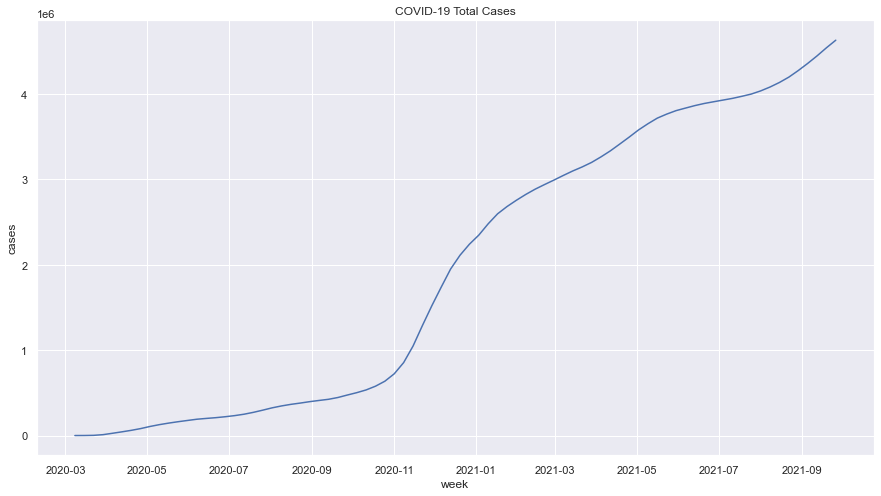

In [417]:
p = sns.lineplot(data=co_covid_data_weekly, x='week', y='cases')
p.set_xlabel=("Week")
p.set_ylabel=("Cumlative Cases")
p.set(title = "COVID-19 Total Cases");

In [127]:
co_covid_data_weekly['new cases'] = co_covid_data_weekly['cases'] - co_covid_data_weekly['cases'].shift(1)
co_covid_data_weekly['new deaths'] = co_covid_data_weekly['deaths'] - co_covid_data_weekly['deaths'].shift(1)
co_covid_data_weekly.head()

,week,cases,deaths,new cases,new deaths
0,2020-03-08,26,0,NaN,NaN
1,2020-03-15,429,7,403.0,7.0
2,2020-03-22,2268,31,1839.0,24.0
3,2020-03-29,10262,186,7994.0,155.0
4,2020-04-05,26398,672,16136.0,486.0


In [128]:
co_covid_data_weekly = co_covid_data_weekly[co_covid_data_weekly['week'] < '2021-10-01']


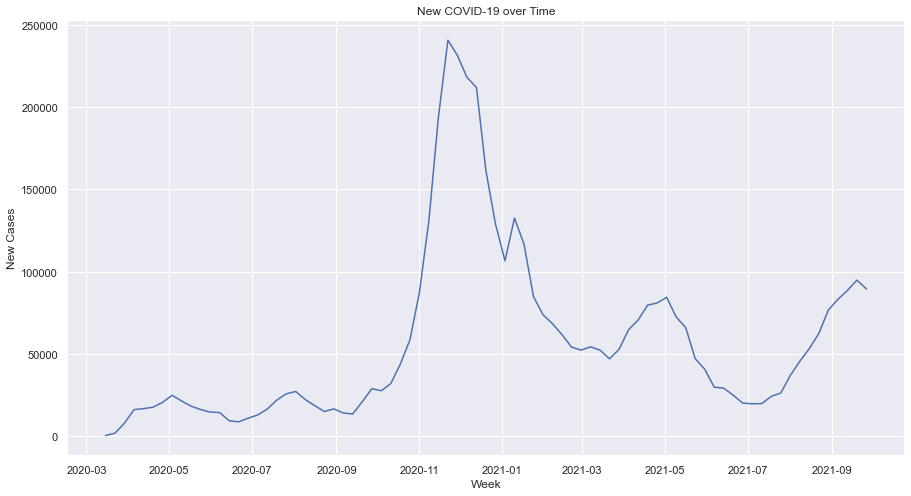

In [418]:
ax = sns.lineplot(data=co_covid_data_weekly, x='week', y='new cases')
ax.set_xlabel("Week")
ax.set_ylabel("New Cases")
ax.set_title("New COVID-19 Cases over Time");

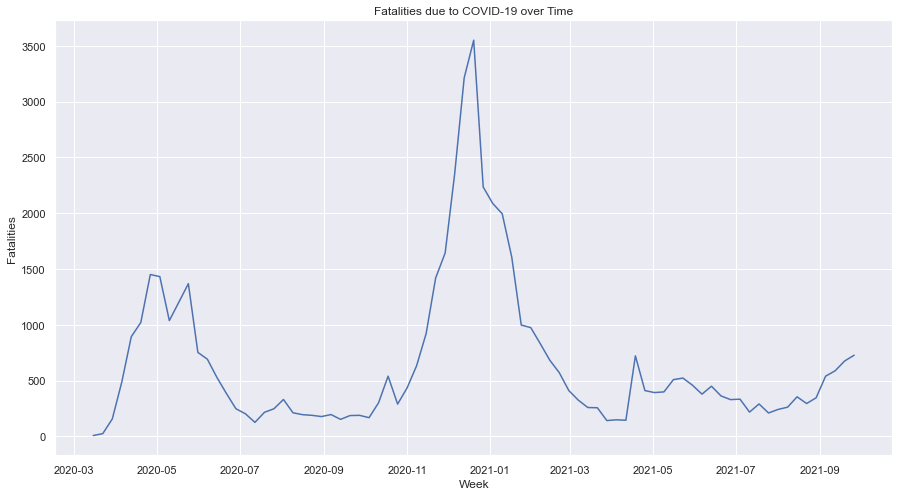

In [419]:
ax = sns.lineplot(data=co_covid_data_weekly, x='week', y='new deaths')
ax.set_xlabel("Week")
ax.set_ylabel("Fatalities")
ax.set(title="Fatalities due to COVID-19 over Time");

In [131]:
df = pd.read_csv('covid_vaccinations.csv')
df = df[["Date","Location","Distributed","Dist_Per_100K","Distributed_Per_100k_18Plus","Administered","Administered_18Plus","Admin_Per_100K","Admin_Per_100k_18Plus"]]
df.head()

colorado_vaccine_df = df[df["Location"] == 'CO']
colorado_vaccine_df['week'] = pd.to_datetime(colorado_vaccine_df['Date'])
colorado_vaccine_df.head(100)

,Date,Location,Distributed,Dist_Per_100K,Distributed_Per_100k_18Plus,Administered,Administered_18Plus,Admin_Per_100K,Admin_Per_100k_18Plus,week
37,08/03/2022,CO,13798775,239615,306693,11341872,10182956,196951,226327,2022-08-03
117,07/27/2022,CO,13717175,238198,304879,11298152,10153464,196192,225672,2022-07-27
170,07/20/2022,CO,13622175,236548,302768,11252672,10121742,195402,224967,2022-07-20
237,07/13/2022,CO,13528275,234917,300681,11208371,10088110,194632,224219,2022-07-13
261,07/06/2022,CO,13441275,233407,298747,11171314,10059976,193989,223594,2022-07-06
...,...,...,...,...,...,...,...,...,...,...
6133,03/20/2022,CO,11989875,208203,266488,10404825,9374662,180679,208362,2022-03-20
6187,03/19/2022,CO,11989875,208203,266488,10404705,9374558,180677,208360,2022-03-19
6225,03/18/2022,CO,11989875,208203,266488,10400295,9371114,180600,208283,2022-03-18
6294,03/17/2022,CO,11975575,207955,266170,10396327,9368002,180531,208214,2022-03-17


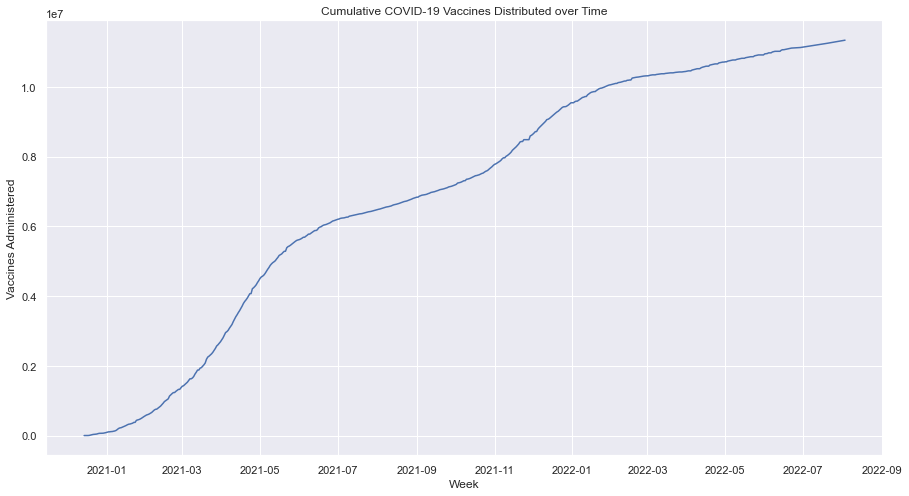

In [423]:
ax = sns.lineplot(data=colorado_vaccine_df, x='week', y='Administered')
ax.set_xlabel("Week")
ax.set_ylabel("Vaccines Administered")
ax.set(title="Cumulative COVID-19 Vaccines Distributed over Time");

In [132]:
colorado_df.rename(columns={"Weeks": "week"},inplace = True)
colorado_df.head(100)


,post_date,state,industry,count_id_indexed,week
96,2020-03-01,CO,NaN,1.0000,2020-03-01
97,2020-03-01,CO,Communication,1.0000,2020-03-01
98,2020-03-01,CO,Construction,1.0000,2020-03-01
99,2020-03-01,CO,Energy,1.0000,2020-03-01
100,2020-03-01,CO,Entertainment,1.0000,2020-03-01
...,...,...,...,...,...
5055,2020-03-06,CO,Wholesale,1.2503,2020-03-06
6032,2020-03-07,CO,NaN,1.0681,2020-03-07
6033,2020-03-07,CO,Communication,1.1555,2020-03-07
6034,2020-03-07,CO,Construction,1.1143,2020-03-07


In [133]:
df = pd.merge(colorado_df, co_covid_data_weekly, on='week')
df

,post_date,state,industry,count_id_indexed,week,cases,deaths,new cases,new deaths
0,2020-03-08,CO,NaN,1.0580,2020-03-08,26,0,NaN,NaN
1,2020-03-08,CO,Communication,1.1413,2020-03-08,26,0,NaN,NaN
2,2020-03-08,CO,Construction,1.0369,2020-03-08,26,0,NaN,NaN
3,2020-03-08,CO,Energy,1.4825,2020-03-08,26,0,NaN,NaN
4,2020-03-08,CO,Entertainment,1.1896,2020-03-08,26,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...
1243,2021-08-29,CO,Real Estate,1.5536,2021-08-29,4275096,50872,76720.0,345.0
1244,2021-08-29,CO,Retail,2.0348,2021-08-29,4275096,50872,76720.0,345.0
1245,2021-08-29,CO,Services,1.5758,2021-08-29,4275096,50872,76720.0,345.0
1246,2021-08-29,CO,Transportation,1.3302,2021-08-29,4275096,50872,76720.0,345.0


In [134]:
df['week']

0      2020-03-08
1      2020-03-08
2      2020-03-08
3      2020-03-08
4      2020-03-08
          ...    
1243   2021-08-29
1244   2021-08-29
1245   2021-08-29
1246   2021-08-29
1247   2021-08-29
Name: week, Length: 1248, dtype: datetime64[ns]

In [135]:
full_df = pd.merge(df, colorado_vaccine_df, on='week', how="outer",)
full_df.rename(columns={"count_id_indexed": "labor_index"},inplace = True)
full_df.drop(columns=["post_date","Date", "Location"],inplace = True)
full_df.head(800)

,state,industry,labor_index,week,cases,deaths,new cases,new deaths,Distributed,Dist_Per_100K,Distributed_Per_100k_18Plus,Administered,Administered_18Plus,Admin_Per_100K,Admin_Per_100k_18Plus
0,CO,NaN,1.0580,2020-03-08,26.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CO,Communication,1.1413,2020-03-08,26.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CO,Construction,1.0369,2020-03-08,26.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CO,Energy,1.4825,2020-03-08,26.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CO,Entertainment,1.1896,2020-03-08,26.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,CO,Real Estate,0.9830,2021-02-14,2886115.0,41150.0,61707.0,682.0,1210475.0,21020.0,26904.0,926807.0,845542.0,16094.0,18793.0
796,CO,Retail,1.0371,2021-02-14,2886115.0,41150.0,61707.0,682.0,1210475.0,21020.0,26904.0,926807.0,845542.0,16094.0,18793.0
797,CO,Services,1.1414,2021-02-14,2886115.0,41150.0,61707.0,682.0,1210475.0,21020.0,26904.0,926807.0,845542.0,16094.0,18793.0
798,CO,Transportation,1.0528,2021-02-14,2886115.0,41150.0,61707.0,682.0,1210475.0,21020.0,26904.0,926807.0,845542.0,16094.0,18793.0


In [136]:
communication_df = full_df[full_df['industry'] == 'Communication']
communication_df

,state,industry,labor_index,week,cases,deaths,new cases,new deaths,Distributed,Dist_Per_100K,Distributed_Per_100k_18Plus,Administered,Administered_18Plus,Admin_Per_100K,Admin_Per_100k_18Plus
1,CO,Communication,1.1413,2020-03-08,26.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,CO,Communication,1.1931,2020-03-15,429.0,7.0,403.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33,CO,Communication,0.6415,2020-03-22,2268.0,31.0,1839.0,24.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49,CO,Communication,0.3397,2020-03-29,10262.0,186.0,7994.0,155.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65,CO,Communication,0.4246,2020-04-05,26398.0,672.0,16136.0,486.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1169,CO,Communication,2.0092,2021-08-01,4037070.0,49618.0,36953.0,241.0,7263185.0,126125.0,161432.0,6484050.0,6059136.0,112595.0,134671.0
1185,CO,Communication,2.0423,2021-08-08,4082623.0,49879.0,45553.0,261.0,7332675.0,127331.0,162977.0,6555288.0,6115136.0,113832.0,135916.0
1201,CO,Communication,1.2073,2021-08-15,4135899.0,50233.0,53276.0,354.0,7408845.0,128654.0,164670.0,6629016.0,6172613.0,115112.0,137193.0
1217,CO,Communication,1.0000,2021-08-22,4198376.0,50527.0,62477.0,294.0,7582565.0,131671.0,168531.0,6711571.0,6241507.0,116546.0,138724.0


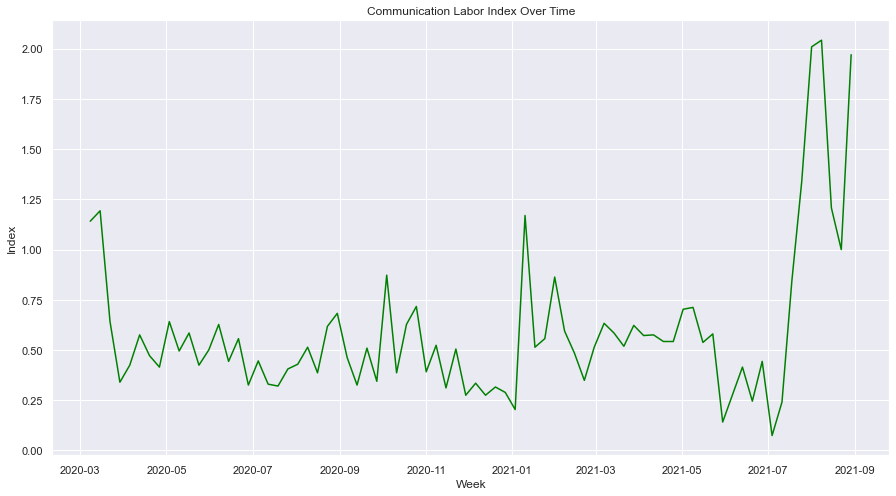

In [137]:
#Plot the data with proper labeling and make some observations on the graph.

plt.plot(communication_df['week'], communication_df['labor_index'], color='green')
plt.title('Communication Labor Index Over Time')
plt.xlabel('Week')
plt.ylabel('Index')
plt.show()

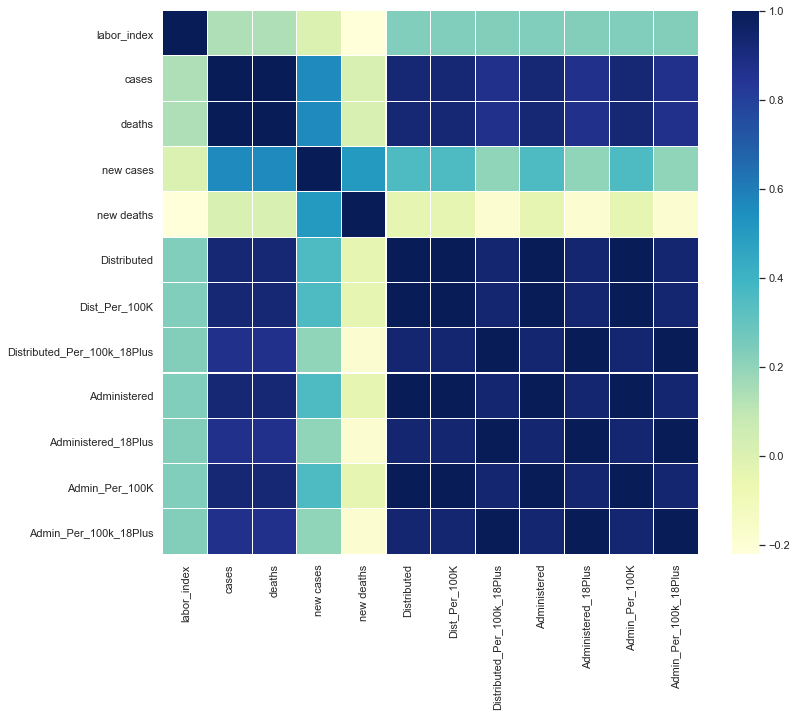

In [272]:
#Correlation Matrix
communication_df = communication_df.fillna(0)
corrmat = communication_df.corr(method='spearman')
f, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corrmat, ax=ax, cmap="YlGnBu", linewidths=0.1);

Coefficients: [ 0.60142605  0.1258084   0.16171434  0.20000162 -0.24821505 -0.06948972
 -0.33685807  0.1572259   0.052054    0.05002558 -0.32513587  0.04117645
 -0.02281017]
predicted=0.325700, expected=0.415000
predicted=0.282644, expected=0.245300
predicted=0.498668, expected=0.443400
predicted=0.490323, expected=0.074300
predicted=0.588651, expected=0.240700
predicted=0.532378, expected=0.844200
predicted=0.527107, expected=1.339400
predicted=0.510065, expected=2.009200
predicted=0.550044, expected=2.042300
predicted=0.531837, expected=1.207300
predicted=0.512698, expected=1.000000
predicted=0.577559, expected=1.970000
Test RMSE: 0.825


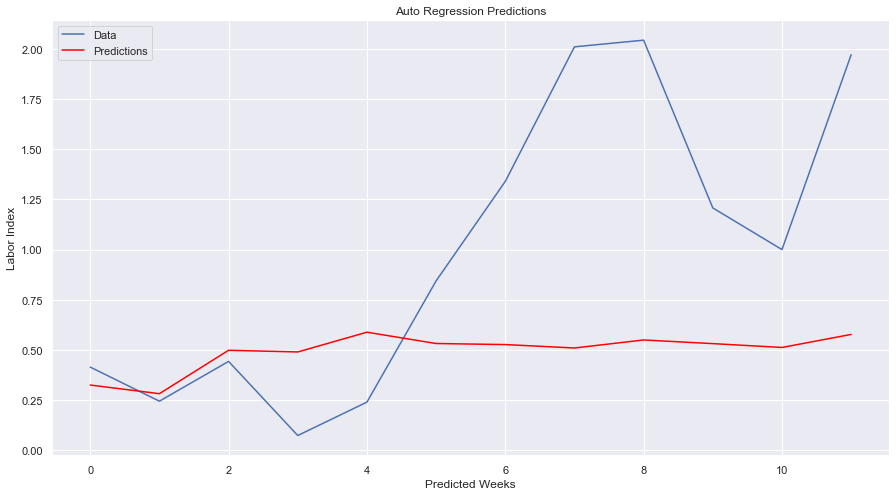

In [285]:
base_communications_df = communication_df[["week","labor_index"]]
base_communications_df


#Filter data, and rset index

base_communications_df['week']=pd.to_datetime(base_communications_df['week'])
base_communications_df.set_index('week', inplace=True)

#check datatype of index
base_communications_df.index

#convert to time series:
ts = base_communications_df['labor_index']
ts

# split dataset
X = ts.values
train, test = X[1:len(X)-12], X[len(X)-12:]

# Train using Autoregression model
model = AutoReg(train, lags=12)
model_fit = model.fit()
print('Coefficients: %s' % model_fit.params)

# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
for i in range(len(predictions)):
    print('predicted=%f, expected=%f' % (predictions[i], test[i]))
ar_rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % ar_rmse)

# plot results
plt.plot(test, label='Data')
plt.plot(predictions, color='red', label='Predictions')
plt.title('Auto Regression Predictions')
plt.xlabel('Predicted Weeks')
plt.ylabel('Labor Index')
plt.legend()
plt.show()


When using just the labor data for my times series model for the Communications industry in Colorado to predict the labor index, I get a RMSE of 0.825

In [183]:
mv_communications_df = communication_df[["week","labor_index", "new cases", "new deaths","Admin_Per_100k_18Plus"]]
mv_communications_df =mv_communications_df.fillna(0)

In [287]:
X_scaler = MinMaxScaler()
Y_scaler = MinMaxScaler()
X_data = X_scaler.fit_transform(mv_communications_df[['new cases', 'new deaths', 'Admin_Per_100k_18Plus']])
Y_data = Y_scaler.fit_transform(mv_communications_df[['labor_index']]) 

len(X_data), len(Y_data)

(78, 78)

In [288]:

#Below is the user-defined function which preprocesses the data suitable for forecasting. 

def custom_ts_multi_data_prep(dataset, target, start, end, window, horizon):
     X = []
     y = []
     start = start + window
     if end is None:
         end = len(dataset) - horizon
     for i in range(start, end):
         indices = range(i-window, i)
         X.append(dataset[indices])
         indicey = range(i+1, i+1+horizon)
         y.append(target[indicey])
     return np.array(X), np.array(y) 

hist_window = 6
horizon = 12
TRAIN_SPLIT = 48
x_train, y_train = custom_ts_multi_data_prep(X_data, Y_data, 0, TRAIN_SPLIT, hist_window, horizon)
x_vali, y_vali = custom_ts_multi_data_prep(X_data, Y_data, TRAIN_SPLIT, None, hist_window, horizon)

#x_train, y_train = X_data[1:len(X)-12], Y_data[1:len(X)-12]
#x_vali, y_vali = X_data[len(X)-12:], Y_data[len(X)-12:]



print ('Multiple window of past history\n')
print(x_train[0])
print ('\n Target horizon\n')
print (y_train[0])

Multiple window of past history

[[0.         0.         0.        ]
 [0.00167377 0.00197183 0.        ]
 [0.00763787 0.00676056 0.        ]
 [0.03320126 0.04366197 0.        ]
 [0.0670172  0.13690141 0.        ]
 [0.06963376 0.2515493  0.        ]]

 Target horizon

[[0.17311992]
 [0.28821138]
 [0.21387195]
 [0.25934959]
 [0.17799797]
 [0.21671748]
 [0.28099593]
 [0.18755081]
 [0.24507114]
 [0.12764228]
 [0.18871951]
 [0.12997967]]


In [296]:
#data = mv_communications_df.drop(['week'], axis=1)
#data.index = mv_communications_df.week
#len(x_train)
#y_vali
#Y_data[len(X)-12:]


In [290]:
#LSTM model
batch_size = 150
buffer_size = 50
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.cache().shuffle(buffer_size).batch(batch_size).repeat()
val_data = tf.data.Dataset.from_tensor_slices((x_vali, y_vali))
val_data = val_data.batch(batch_size).repeat()

lstm_model = tf.keras.models.Sequential([
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(200, return_sequences=True), 
                                input_shape=x_train.shape[-2:]),
     tf.keras.layers.Dense(20, activation='tanh'),
     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(150)),
     tf.keras.layers.Dense(20, activation='tanh'),
     tf.keras.layers.Dense(20, activation='tanh'),
     tf.keras.layers.Dropout(0.25),
     tf.keras.layers.Dense(units=horizon),
 ])
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.summary() 

model_path = 'Bidirectional_LSTM_Multivariate.h5'
early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min')
checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
callbacks=[early_stopings,checkpoint] 
history = lstm_model.fit(train_data,epochs=20,steps_per_epoch=100,validation_data=val_data,validation_steps=50,verbose=1,callbacks=callbacks)



Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_32 (Bidirecti  (None, 6, 400)           326400    
 onal)                                                           
                                                                 
 dense_64 (Dense)            (None, 6, 20)             8020      
                                                                 
 bidirectional_33 (Bidirecti  (None, 300)              205200    
 onal)                                                           
                                                                 
 dense_65 (Dense)            (None, 20)                6020      
                                                                 
 dense_66 (Dense)            (None, 20)                420       
                                                                 
 dropout_16 (Dropout)        (None, 20)              

In [298]:
#val_data

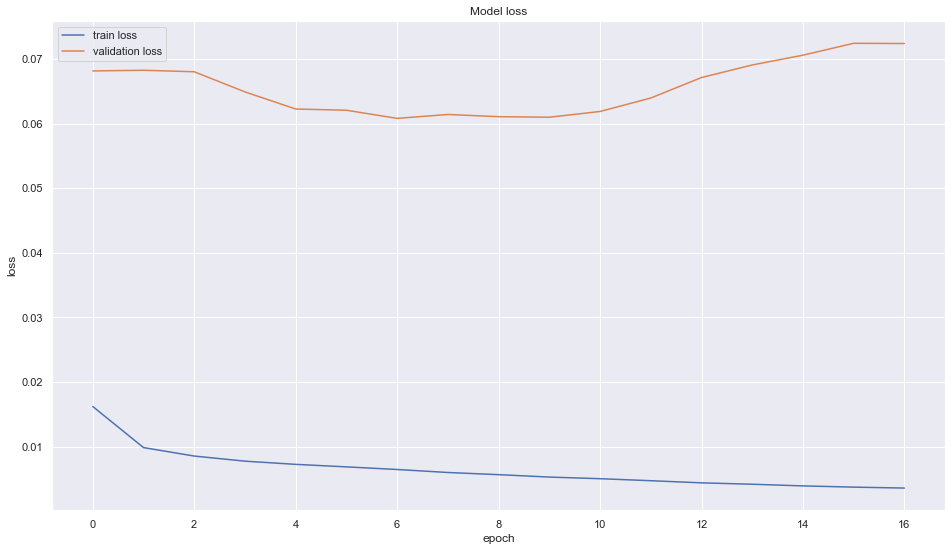

In [299]:
#Look at Training and validation loss curves
plt.figure(figsize=(16,9))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'])
plt.show() 

In [303]:
data_val = X_scaler.fit_transform(mv_communications_df[['new cases', 'new deaths', 'Admin_Per_100k_18Plus']].tail(1))
val_rescaled = data_val.reshape(1, data_val.shape[0], data_val.shape[1])
pred = lstm_model.predict(val_rescaled)
pred_Inverse = Y_scaler.inverse_transform(pred)
pred_Inverse 

1/1 [==============================] - 0s 27ms/step


array([[0.4899219 , 0.41191933, 0.46794182, 0.44979656, 0.46331212,
        0.40238503, 0.5111442 , 0.4819008 , 0.519972  , 0.72476304,
        0.6471353 , 0.6854151 ]], dtype=float32)

In [304]:
y_vali[0], 

(array([[0.27860772],
        [0.25294715],
        [0.25462398],
        [0.23785569],
        [0.23785569],
        [0.31941057],
        [0.32408537],
        [0.23551829],
        [0.2570122 ],
        [0.03419715],
        [0.10365854],
        [0.17311992]]),)

Evaluation metric results:-
MSE is : 0.016273125035778158
MAE is : 0.10213074406513033
RMSE is : 0.12756615944590538
MAPE is : 76.99134141473183
R2 is : -1.4862160245237614



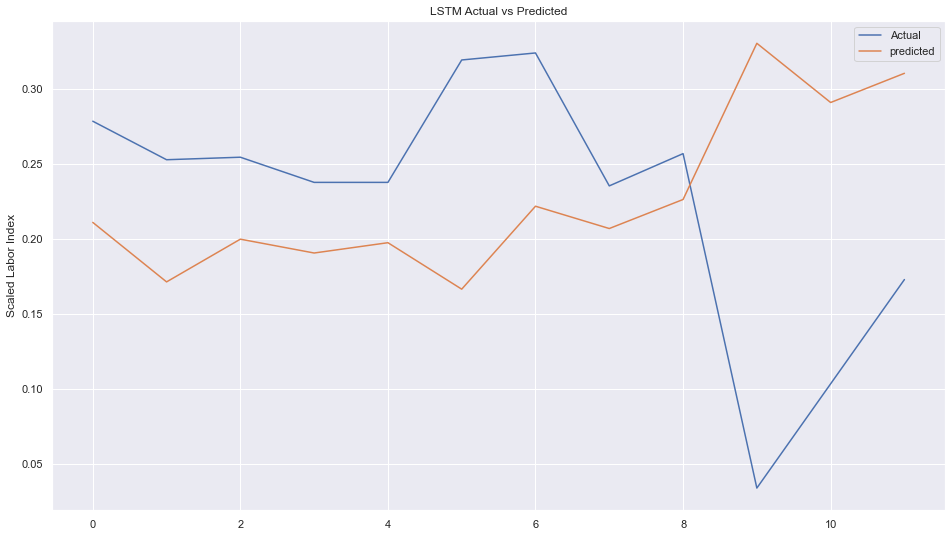

In [307]:
def timeseries_evaluation_metrics_func(y_true, y_pred):
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n') 
timeseries_evaluation_metrics_func(y_vali[0],pred[0])


plt.figure(figsize=(16,9))
plt.plot( list(y_vali[0]))
plt.plot( list(pred[0]))
plt.title("LSTM Actual vs Predicted")
plt.ylabel("Scaled Labor Index")
plt.legend(('Actual','predicted'))
plt.show() 

In [388]:
###### Healthcare models
healthcare_df = full_df[full_df['industry'] == 'Healthcare']


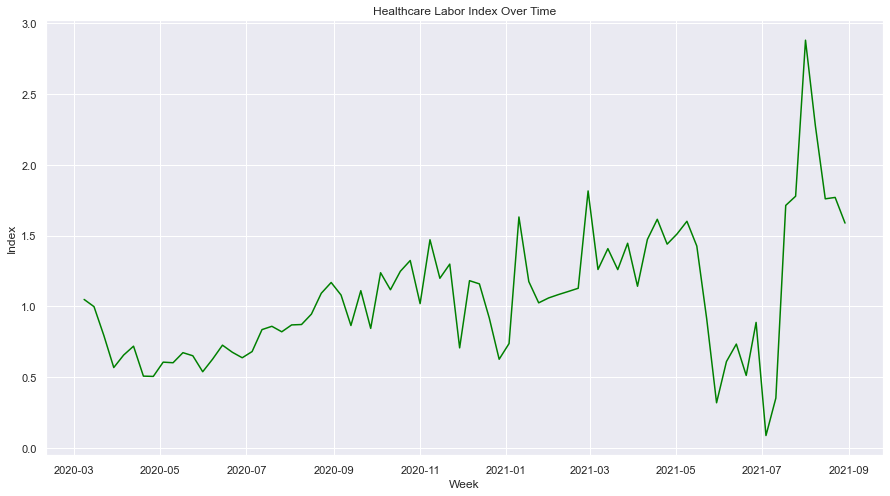

In [389]:
#Plot the data with proper labeling and make some observations on the graph.

plt.plot(healthcare_df['week'], healthcare_df['labor_index'], color='green')
plt.title('Healthcare Labor Index Over Time')
plt.xlabel('Week')
plt.ylabel('Index')
plt.show()

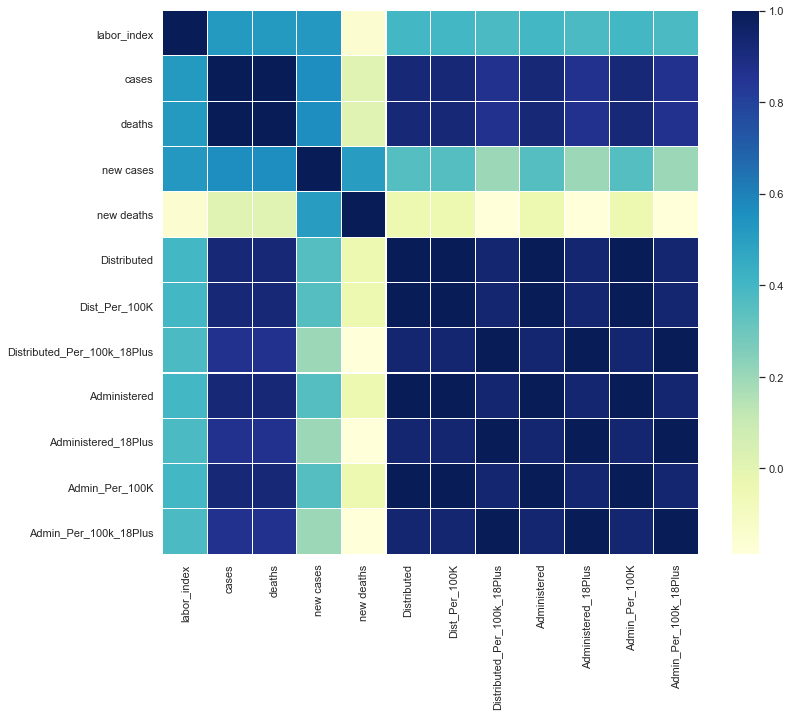

In [390]:
#Correlation Matrix
healthcare_df = healthcare_df.fillna(0)
corrmat = healthcare_df.corr(method='spearman')
f, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corrmat, ax=ax, cmap="YlGnBu", linewidths=0.1);

Coefficients: [ 0.324874    0.6740107   0.04924938 -0.3288888   0.52625976 -0.22330232
 -0.29653577  0.65694188 -0.39468281  0.09456323  0.20235307 -0.26450493
  0.00168788]
predicted=0.694636, expected=0.733400
predicted=0.981203, expected=0.512000
predicted=0.891482, expected=0.886500
predicted=1.039287, expected=0.087400
predicted=0.997279, expected=0.351900
predicted=0.846127, expected=1.713000
predicted=0.875408, expected=1.777900
predicted=0.741400, expected=2.880100
predicted=0.871460, expected=2.275100
predicted=0.879977, expected=1.759500
predicted=1.096526, expected=1.769400
predicted=1.109562, expected=1.588100
Test RMSE: 0.962


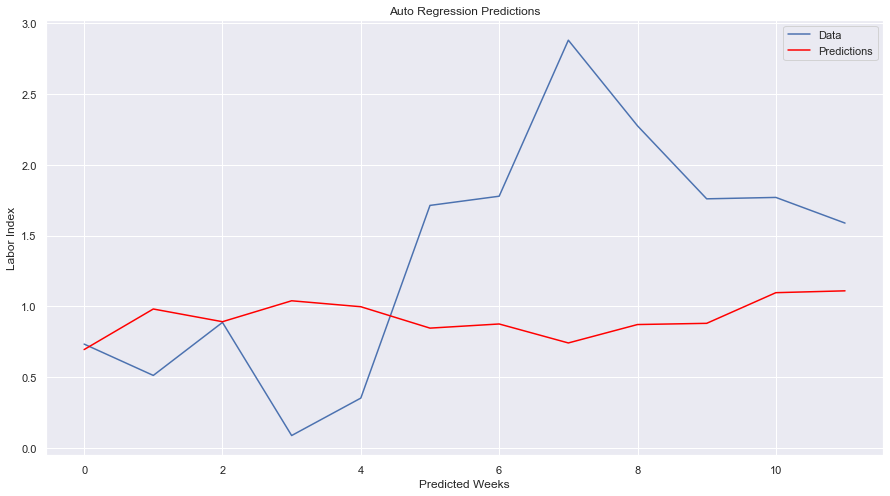

In [391]:
####Healthcare Autoregression

base_healthcare_df = healthcare_df[["week","labor_index"]]
base_healthcare_df


#Filter data, and rset index

base_healthcare_df['week']=pd.to_datetime(base_healthcare_df['week'])
base_healthcare_df.set_index('week', inplace=True)

#check datatype of index
base_healthcare_df.index

#convert to time series:
ts = base_healthcare_df['labor_index']
ts

# split dataset
X = ts.values
train, test = X[1:len(X)-12], X[len(X)-12:]

# Train using Autoregression model
model = AutoReg(train, lags=12)
model_fit = model.fit()
print('Coefficients: %s' % model_fit.params)

# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
for i in range(len(predictions)):
    print('predicted=%f, expected=%f' % (predictions[i], test[i]))
ar_rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % ar_rmse)

# plot results
plt.plot(test, label='Data')
plt.plot(predictions, color='red', label='Predictions')
plt.title('Auto Regression Predictions')
plt.xlabel('Predicted Weeks')
plt.ylabel('Labor Index')
plt.legend()
plt.show()


In [392]:
mv_healthcare_df = healthcare_df[["week","labor_index", "new cases", "new deaths","Admin_Per_100k_18Plus"]]
mv_healthcare_df =mv_healthcare_df.fillna(0)

X_scaler = MinMaxScaler()
Y_scaler = MinMaxScaler()
X_data = X_scaler.fit_transform(mv_healthcare_df[['new cases', 'new deaths', 'Admin_Per_100k_18Plus']])
Y_data = Y_scaler.fit_transform(mv_healthcare_df[['labor_index']]) 

print(len(X_data), len(Y_data))

hist_window = 6
horizon = 12
TRAIN_SPLIT = 48
x_train, y_train = custom_ts_multi_data_prep(X_data, Y_data, 0, TRAIN_SPLIT, hist_window, horizon)
x_vali, y_vali = custom_ts_multi_data_prep(X_data, Y_data, TRAIN_SPLIT, None, hist_window, horizon)

#x_train, y_train = X_data[1:len(X)-12], Y_data[1:len(X)-12]
#x_vali, y_vali = X_data[len(X)-12:], Y_data[len(X)-12:]



print ('Multiple window of past history\n')
print(x_train[0])
print ('\n Target horizon\n')
print (y_train[0])

78 78
Multiple window of past history

[[0.         0.         0.        ]
 [0.00167377 0.00197183 0.        ]
 [0.00763787 0.00676056 0.        ]
 [0.03320126 0.04366197 0.        ]
 [0.0670172  0.13690141 0.        ]
 [0.06963376 0.2515493  0.        ]]

 Target horizon

[[0.14953271]
 [0.18562681]
 [0.18412289]
 [0.20961793]
 [0.20177606]
 [0.16138504]
 [0.19318223]
 [0.22856017]
 [0.21062055]
 [0.19672718]
 [0.21241093]
 [0.26794858]]


Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_52 (Bidirecti  (None, 6, 400)           326400    
 onal)                                                           
                                                                 
 dense_104 (Dense)           (None, 6, 20)             8020      
                                                                 
 bidirectional_53 (Bidirecti  (None, 300)              205200    
 onal)                                                           
                                                                 
 dense_105 (Dense)           (None, 20)                6020      
                                                                 
 dense_106 (Dense)           (None, 20)                420       
                                                                 
 dropout_26 (Dropout)        (None, 20)              

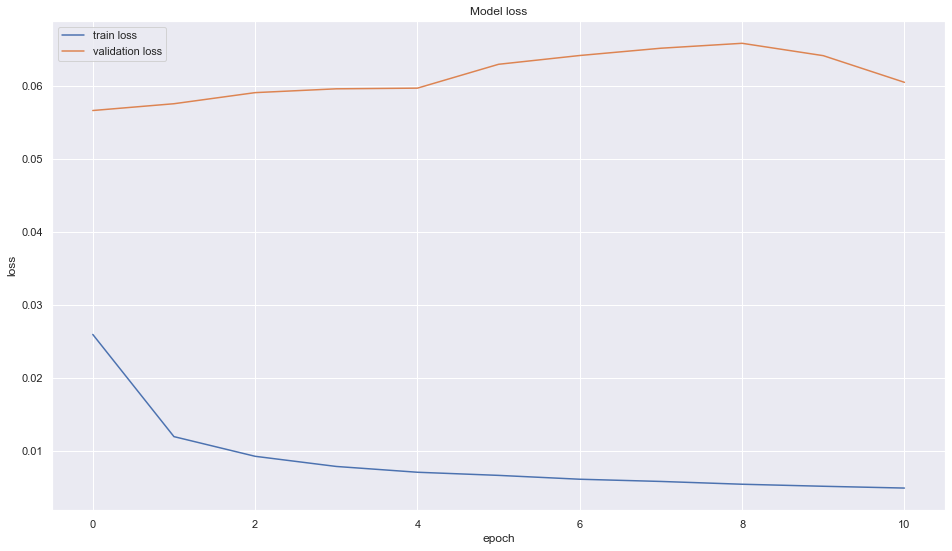

In [393]:
#LSTM model
batch_size = 150
buffer_size = 50
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.cache().shuffle(buffer_size).batch(batch_size).repeat()
val_data = tf.data.Dataset.from_tensor_slices((x_vali, y_vali))
val_data = val_data.batch(batch_size).repeat()

lstm_model = tf.keras.models.Sequential([
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(200, return_sequences=True), 
                                input_shape=x_train.shape[-2:]),
     tf.keras.layers.Dense(20, activation='tanh'),
     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(150)),
     tf.keras.layers.Dense(20, activation='tanh'),
     tf.keras.layers.Dense(20, activation='tanh'),
     tf.keras.layers.Dropout(0.25),
     tf.keras.layers.Dense(units=horizon),
 ])
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.summary() 

model_path = 'Bidirectional_LSTM_Multivariate.h5'
early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min')
checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
callbacks=[early_stopings,checkpoint] 
history = lstm_model.fit(train_data,epochs=25,steps_per_epoch=100,validation_data=val_data,validation_steps=50,verbose=1,callbacks=callbacks)

#Look at Training and validation loss curves
plt.figure(figsize=(16,9))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'])
plt.show() 



In [394]:
### Plot Healthcare
data_val = X_scaler.fit_transform(mv_healthcare_df[['new cases', 'new deaths', 'Admin_Per_100k_18Plus']].tail(6))
data_val

array([[0.        , 0.        , 0.        ],
       [0.21153541, 0.22068966, 0.16920863],
       [0.38204854, 0.35862069, 0.34834532],
       [0.53517329, 1.        , 0.53208633],
       [0.71760251, 0.5862069 , 0.7523741 ],
       [1.        , 0.93793103, 1.        ]])

1/1 [==============================] - 1s 1s/step
Evaluation metric results:-
MSE is : 0.0423581865022444
MAE is : 0.18893927642140385
RMSE is : 0.20581104562740163
MAPE is : 55.1252834329719
R2 is : -0.8890122770686193



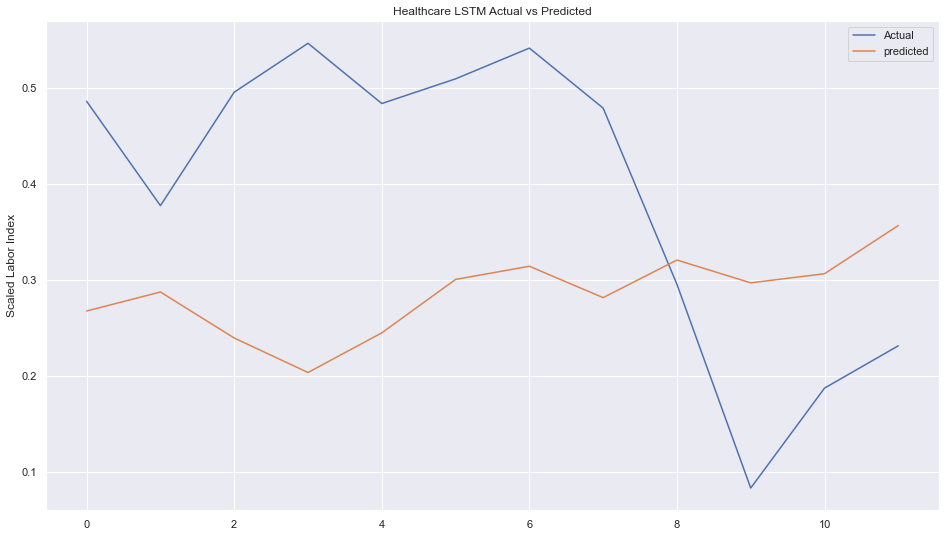

In [395]:
val_rescaled = data_val.reshape(1, data_val.shape[0], data_val.shape[1])
pred = lstm_model.predict(val_rescaled)
pred_Inverse = Y_scaler.inverse_transform(pred)
pred_Inverse

timeseries_evaluation_metrics_func(y_vali[0],pred[0])


plt.figure(figsize=(16,9))
plt.plot( list(y_vali[0]))
plt.plot( list(pred[0]))
plt.title("Healthcare LSTM Actual vs Predicted")
plt.ylabel("Scaled Labor Index")
plt.legend(('Actual','predicted'))
plt.show() 

In [396]:
pred

array([[0.2676083 , 0.2874483 , 0.2394235 , 0.20345056, 0.24481755,
        0.30056703, 0.3142929 , 0.28157452, 0.32078946, 0.29700124,
        0.30650982, 0.35682672]], dtype=float32)

In [397]:
###### Retail models
retail_df = full_df[full_df['industry'] == 'Retail']


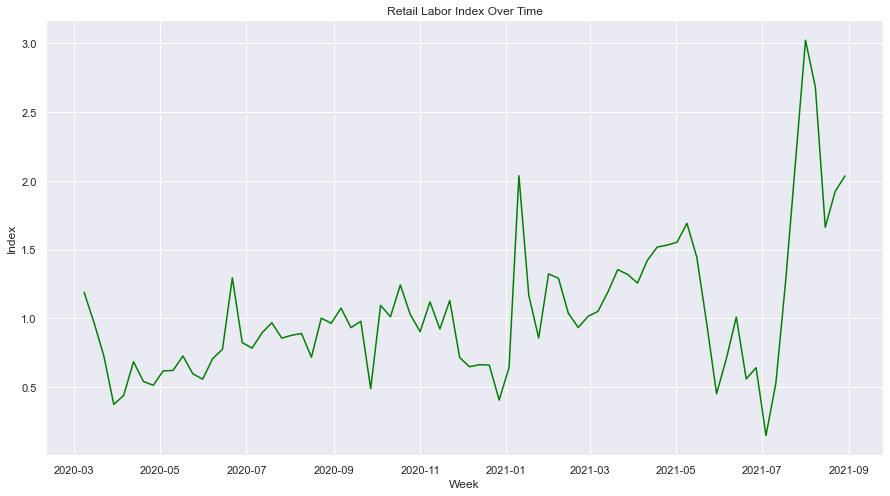

In [398]:
      #Plot the data with proper labeling and make some observations on the graph.

plt.plot(retail_df['week'], retail_df['labor_index'], color='green')
plt.title('Retail Labor Index Over Time')
plt.xlabel('Week')
plt.ylabel('Index')
plt.show()

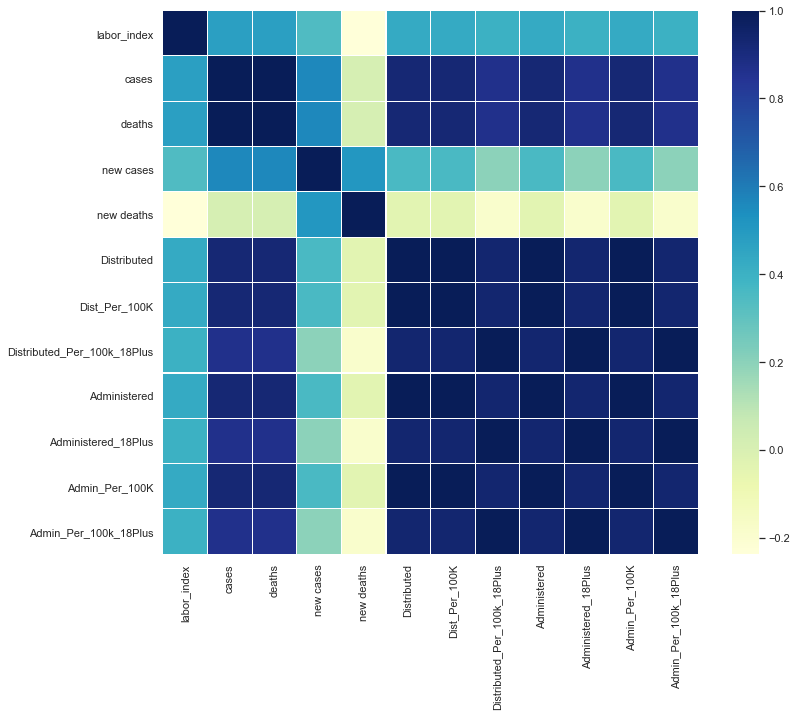

In [399]:
#Correlation Matrix
retail_df = retail_df.fillna(0)
corrmat = retail_df.corr(method='spearman')
f, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corrmat, ax=ax, cmap="YlGnBu", linewidths=0.1);

Coefficients: [ 0.41174207  0.50664176 -0.10997302  0.11378678  0.06419453 -0.13572319
 -0.11101254  0.15025476 -0.21313278  0.21458948 -0.02983182  0.07845145
  0.09817917]
predicted=0.932888, expected=1.009900
predicted=0.954250, expected=0.559400
predicted=1.052542, expected=0.641200
predicted=1.226276, expected=0.148400
predicted=1.362055, expected=0.528700
predicted=1.336676, expected=1.277100
predicted=1.372436, expected=2.148400
predicted=1.281440, expected=3.021400
predicted=1.167084, expected=2.679400
predicted=1.047056, expected=1.662000
predicted=0.952098, expected=1.922300
predicted=0.942915, expected=2.034800
Test RMSE: 0.941


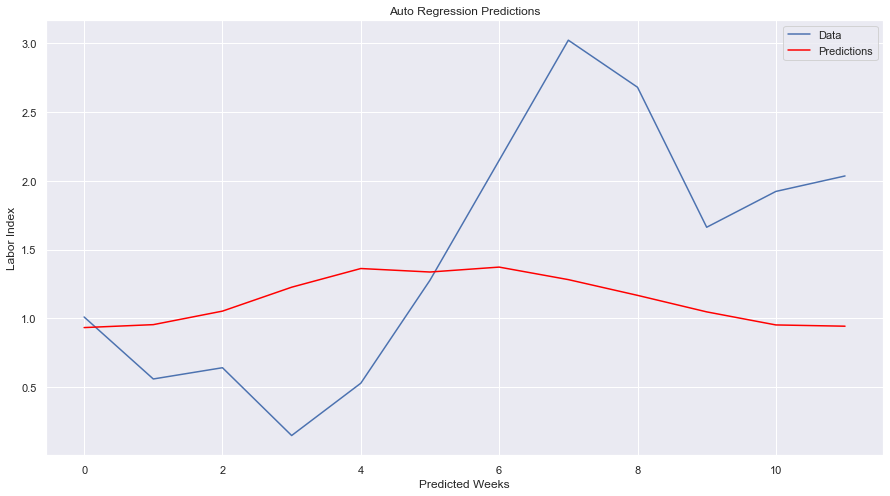

In [400]:
####Retail Autoregression

base_retail_df = retail_df[["week","labor_index"]]
base_retail_df


#Filter data, and rset index

base_retail_df['week']=pd.to_datetime(base_retail_df['week'])
base_retail_df.set_index('week', inplace=True)

#check datatype of index
base_retail_df.index

#convert to time series:
ts = base_retail_df['labor_index']
ts

# split dataset
X = ts.values
train, test = X[1:len(X)-12], X[len(X)-12:]

# Train using Autoregression model
model = AutoReg(train, lags=12)
model_fit = model.fit()
print('Coefficients: %s' % model_fit.params)

# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
for i in range(len(predictions)):
    print('predicted=%f, expected=%f' % (predictions[i], test[i]))
ar_rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % ar_rmse)

# plot results
plt.plot(test, label='Data')
plt.plot(predictions, color='red', label='Predictions')
plt.title('Auto Regression Predictions')
plt.xlabel('Predicted Weeks')
plt.ylabel('Labor Index')
plt.legend()
plt.show()


In [401]:
mv_retail_df = retail_df[["week","labor_index", "new cases", "new deaths","Admin_Per_100k_18Plus"]]
mv_retail_df =mv_retail_df.fillna(0)

X_scaler = MinMaxScaler()
Y_scaler = MinMaxScaler()
X_data = X_scaler.fit_transform(mv_retail_df[['new cases', 'new deaths', 'Admin_Per_100k_18Plus']])
Y_data = Y_scaler.fit_transform(mv_retail_df[['labor_index']]) 

len(X_data), len(Y_data)

hist_window = 6
horizon = 12
TRAIN_SPLIT = 48
x_train, y_train = custom_ts_multi_data_prep(X_data, Y_data, 0, TRAIN_SPLIT, hist_window, horizon)
x_vali, y_vali = custom_ts_multi_data_prep(X_data, Y_data, TRAIN_SPLIT, None, hist_window, horizon)

#x_train, y_train = X_data[1:len(X)-12], Y_data[1:len(X)-12]
#x_vali, y_vali = X_data[len(X)-12:], Y_data[len(X)-12:]



print ('Multiple window of past history\n')
print(x_train[0])
print ('\n Target horizon\n')
print (y_train[0])

Multiple window of past history

[[0.         0.         0.        ]
 [0.00167377 0.00197183 0.        ]
 [0.00763787 0.00676056 0.        ]
 [0.03320126 0.04366197 0.        ]
 [0.0670172  0.13690141 0.        ]
 [0.06963376 0.2515493  0.        ]]

 Target horizon

[[0.12711451]
 [0.16345284]
 [0.16463627]
 [0.20118343]
 [0.15617821]
 [0.14246432]
 [0.19432649]
 [0.21813435]
 [0.39892099]
 [0.23508528]
 [0.22116255]
 [0.2596937 ]]


Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_54 (Bidirecti  (None, 6, 400)           326400    
 onal)                                                           
                                                                 
 dense_108 (Dense)           (None, 6, 20)             8020      
                                                                 
 bidirectional_55 (Bidirecti  (None, 300)              205200    
 onal)                                                           
                                                                 
 dense_109 (Dense)           (None, 20)                6020      
                                                                 
 dense_110 (Dense)           (None, 20)                420       
                                                                 
 dropout_27 (Dropout)        (None, 20)              

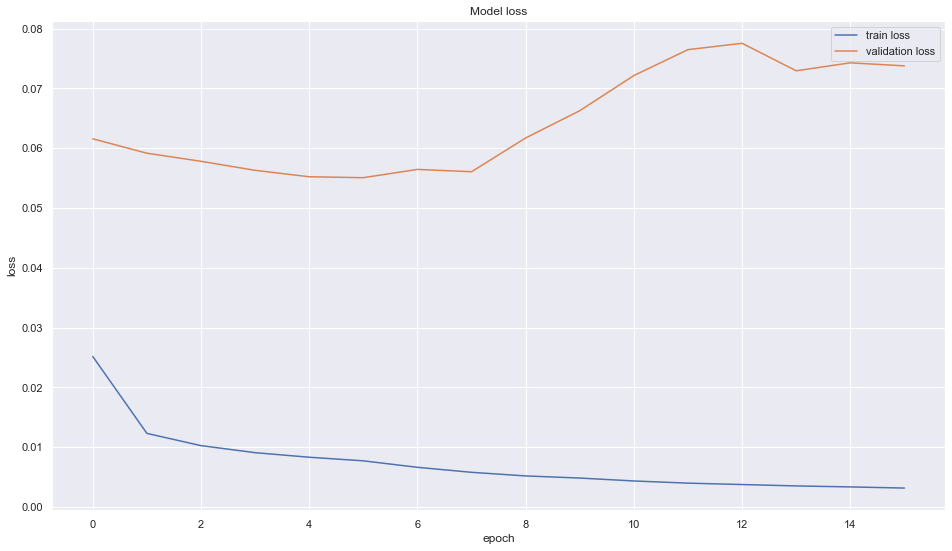

In [402]:
#LSTM model
batch_size = 150
buffer_size = 50
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.cache().shuffle(buffer_size).batch(batch_size).repeat()
val_data = tf.data.Dataset.from_tensor_slices((x_vali, y_vali))
val_data = val_data.batch(batch_size).repeat()

lstm_model = tf.keras.models.Sequential([
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(200, return_sequences=True), 
                                input_shape=x_train.shape[-2:]),
     tf.keras.layers.Dense(20, activation='tanh'),
     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(150)),
     tf.keras.layers.Dense(20, activation='tanh'),
     tf.keras.layers.Dense(20, activation='tanh'),
     tf.keras.layers.Dropout(0.25),
     tf.keras.layers.Dense(units=horizon),
 ])
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.summary() 

model_path = 'Bidirectional_LSTM_Multivariate.h5'
early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min')
checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
callbacks=[early_stopings,checkpoint] 
history = lstm_model.fit(train_data,epochs=20,steps_per_epoch=100,validation_data=val_data,validation_steps=50,verbose=1,callbacks=callbacks)

#Look at Training and validation loss curves
plt.figure(figsize=(16,9))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'])
plt.show() 



1/1 [==============================] - 3s 3s/step
Evaluation metric results:-
MSE is : 0.035388514776694385
MAE is : 0.14784901002833664
RMSE is : 0.18811835310966973
MAPE is : 54.90867310972104
R2 is : -1.2246928648467281



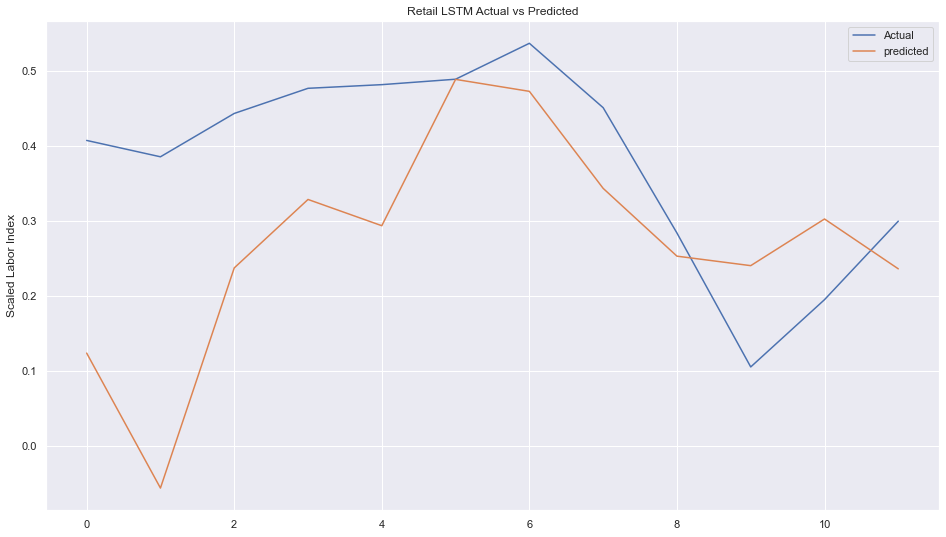

In [403]:
###Plot Retail
### Plot Healthcare
data_val = X_scaler.fit_transform(mv_retail_df[['new cases', 'new deaths', 'Admin_Per_100k_18Plus']].tail(6))
pred = lstm_model.predict(val_rescaled)
pred_Inverse = Y_scaler.inverse_transform(pred)
pred_Inverse

timeseries_evaluation_metrics_func(y_vali[0],pred[0])


plt.figure(figsize=(16,9))
plt.plot( list(y_vali[0]))
plt.plot( list(pred[0]))
plt.title("Retail LSTM Actual vs Predicted")
plt.ylabel("Scaled Labor Index")
plt.legend(('Actual','predicted'))
plt.show() 

In [404]:
pred

array([[ 0.12419049, -0.05554581,  0.23759519,  0.3287718 ,  0.2938062 ,
         0.4886605 ,  0.4727363 ,  0.34354246,  0.25327107,  0.24062817,
         0.30276972,  0.23637578]], dtype=float32)

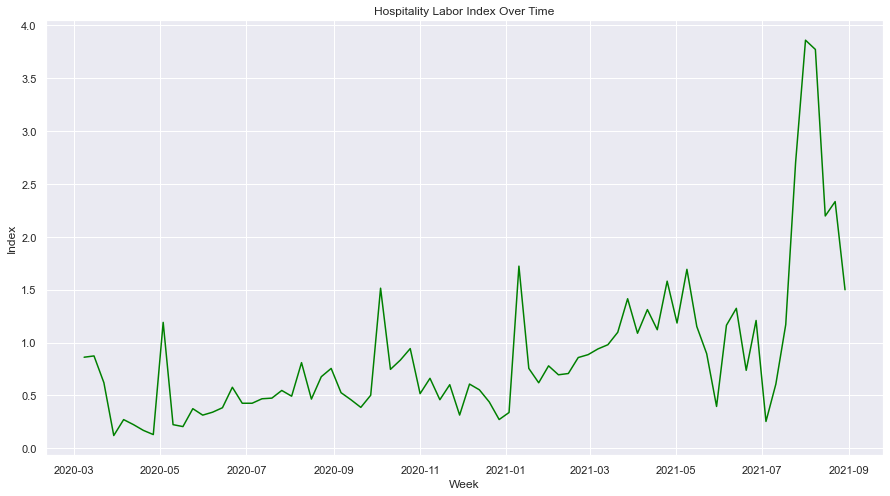

In [405]:
###### Retail models
hospitality_df = full_df[full_df['industry'] == 'Hospitality']

#Plot the data with proper labeling and make some observations on the graph.

plt.plot(hospitality_df['week'], hospitality_df['labor_index'], color='green')
plt.title('Hospitality Labor Index Over Time')
plt.xlabel('Week')
plt.ylabel('Index')
plt.show()

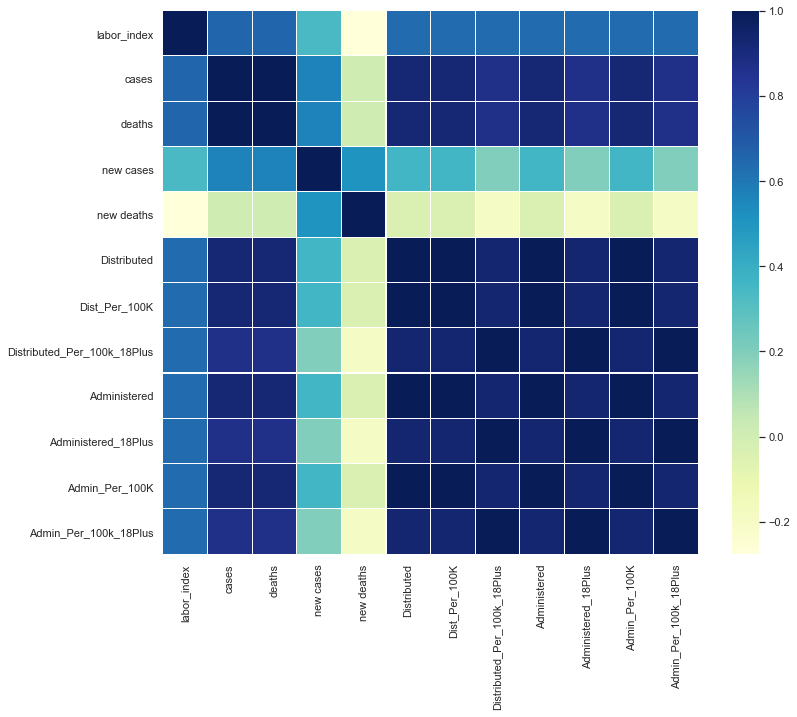

In [406]:
#Correlation Matrix
hospitality_df = hospitality_df.fillna(0)
corrmat = hospitality_df.corr(method='spearman')
f, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corrmat, ax=ax, cmap="YlGnBu", linewidths=0.1);

Coefficients: [ 0.20124672  0.26835799  0.15876144  0.04606866  0.1147215   0.03977483
  0.03716807  0.08049165 -0.01123024 -0.03198542  0.0202243   0.15811015
 -0.09884026]
predicted=1.070479, expected=1.323100
predicted=1.003087, expected=0.737200
predicted=1.012510, expected=1.208300
predicted=0.979250, expected=0.253800
predicted=1.022673, expected=0.607100
predicted=0.928965, expected=1.169200
predicted=1.088129, expected=2.703700
predicted=0.971062, expected=3.857700
predicted=0.938446, expected=3.770100
predicted=0.874698, expected=2.196200
predicted=1.031293, expected=2.332200
predicted=0.962836, expected=1.498400
Test RMSE: 1.403


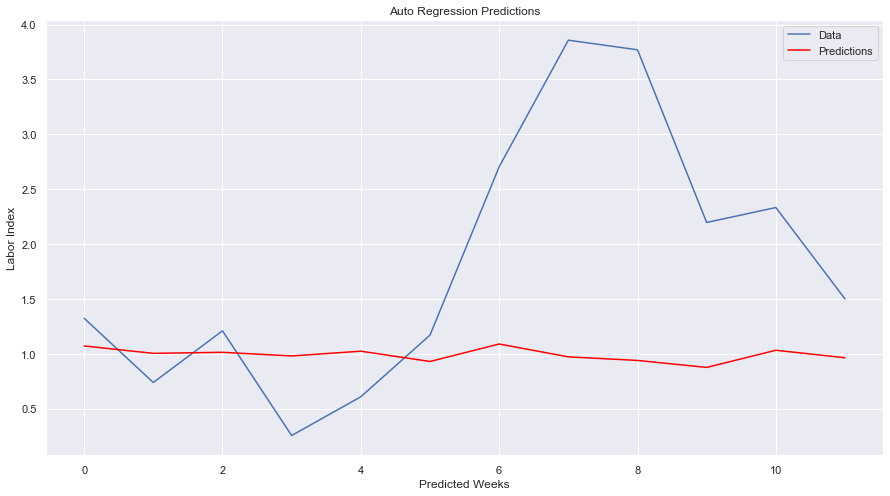

In [407]:
####Retail Autoregression

base_hospitality_df = hospitality_df[["week","labor_index"]]
base_hospitality_df


#Filter data, and rset index

base_hospitality_df['week']=pd.to_datetime(base_hospitality_df['week'])
base_hospitality_df.set_index('week', inplace=True)

#check datatype of index
base_hospitality_df.index

#convert to time series:
ts = base_hospitality_df['labor_index']
ts

# split dataset
X = ts.values
train, test = X[1:len(X)-12], X[len(X)-12:]

# Train using Autoregression model
model = AutoReg(train, lags=12)
model_fit = model.fit()
print('Coefficients: %s' % model_fit.params)

# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
for i in range(len(predictions)):
    print('predicted=%f, expected=%f' % (predictions[i], test[i]))
ar_rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % ar_rmse)

# plot results
plt.plot(test, label='Data')
plt.plot(predictions, color='red', label='Predictions')
plt.title('Auto Regression Predictions')
plt.xlabel('Predicted Weeks')
plt.ylabel('Labor Index')
plt.legend()
plt.show()


In [408]:
mv_hospitality_df = hospitality_df[["week","labor_index", "new cases", "new deaths","Admin_Per_100k_18Plus"]]
mv_hospitality_df =mv_hospitality_df.fillna(0)

X_scaler = MinMaxScaler()
Y_scaler = MinMaxScaler()
X_data = X_scaler.fit_transform(mv_hospitality_df[['new cases', 'new deaths', 'Admin_Per_100k_18Plus']])
Y_data = Y_scaler.fit_transform(mv_hospitality_df[['labor_index']]) 

len(X_data), len(Y_data)

hist_window = 6
horizon = 12
TRAIN_SPLIT = 48
x_train, y_train = custom_ts_multi_data_prep(X_data, Y_data, 0, TRAIN_SPLIT, hist_window, horizon)
x_vali, y_vali = custom_ts_multi_data_prep(X_data, Y_data, TRAIN_SPLIT, None, hist_window, horizon)

#x_train, y_train = X_data[1:len(X)-12], Y_data[1:len(X)-12]
#x_vali, y_vali = X_data[len(X)-12:], Y_data[len(X)-12:]



print ('Multiple window of past history\n')
print(x_train[0])
print ('\n Target horizon\n')
print (y_train[0])

Multiple window of past history

[[0.         0.         0.        ]
 [0.00167377 0.00197183 0.        ]
 [0.00763787 0.00676056 0.        ]
 [0.03320126 0.04366197 0.        ]
 [0.0670172  0.13690141 0.        ]
 [0.06963376 0.2515493  0.        ]]

 Target horizon

[[0.00243511]
 [0.28621889]
 [0.0275087 ]
 [0.02263848]
 [0.06791544]
 [0.05161895]
 [0.05903131]
 [0.07035055]
 [0.12213005]
 [0.08166979]
 [0.08166979]
 [0.09298903]]


Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_56 (Bidirecti  (None, 6, 400)           326400    
 onal)                                                           
                                                                 
 dense_112 (Dense)           (None, 6, 20)             8020      
                                                                 
 bidirectional_57 (Bidirecti  (None, 300)              205200    
 onal)                                                           
                                                                 
 dense_113 (Dense)           (None, 20)                6020      
                                                                 
 dense_114 (Dense)           (None, 20)                420       
                                                                 
 dropout_28 (Dropout)        (None, 20)              

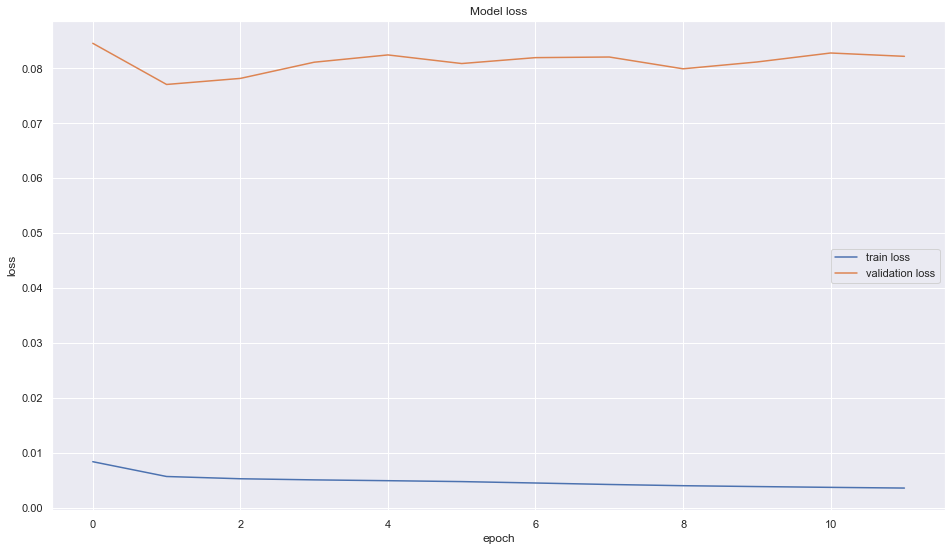

In [409]:
#LSTM model
batch_size = 150
buffer_size = 50
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.cache().shuffle(buffer_size).batch(batch_size).repeat()
val_data = tf.data.Dataset.from_tensor_slices((x_vali, y_vali))
val_data = val_data.batch(batch_size).repeat()

lstm_model = tf.keras.models.Sequential([
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(200, return_sequences=True), 
                                input_shape=x_train.shape[-2:]),
     tf.keras.layers.Dense(20, activation='tanh'),
     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(150)),
     tf.keras.layers.Dense(20, activation='tanh'),
     tf.keras.layers.Dense(20, activation='tanh'),
     tf.keras.layers.Dropout(0.25),
     tf.keras.layers.Dense(units=horizon),
 ])
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.summary() 

model_path = 'Bidirectional_LSTM_Multivariate.h5'
early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min')
checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
callbacks=[early_stopings,checkpoint] 
history = lstm_model.fit(train_data,epochs=20,steps_per_epoch=100,validation_data=val_data,validation_steps=50,verbose=1,callbacks=callbacks)

#Look at Training and validation loss curves
plt.figure(figsize=(16,9))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'])
plt.show() 



1/1 [==============================] - 1s 1s/step
Evaluation metric results:-
MSE is : 0.04688659761191722
MAE is : 0.18424434544912852
RMSE is : 0.21653313282709696
MAPE is : 61.93761641760466
R2 is : -5.429334166648781



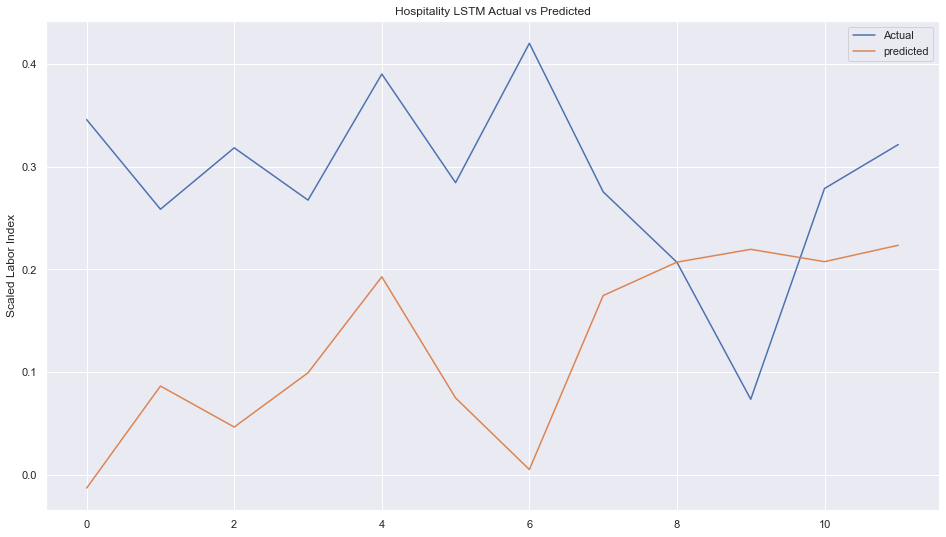

In [410]:
###Plot Retail
### Plot Healthcare
data_val = X_scaler.fit_transform(mv_hospitality_df[['new cases', 'new deaths', 'Admin_Per_100k_18Plus']].tail(6))
pred = lstm_model.predict(val_rescaled)
pred_Inverse = Y_scaler.inverse_transform(pred)
pred_Inverse

timeseries_evaluation_metrics_func(y_vali[0],pred[0])


plt.figure(figsize=(16,9))
plt.plot( list(y_vali[0]))
plt.plot( list(pred[0]))
plt.title("Hospitality LSTM Actual vs Predicted")
plt.ylabel("Scaled Labor Index")
plt.legend(('Actual','predicted'))
plt.show() 